In [1]:
import os, pickle
import pandas as pd
import numpy as np
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances as euc_dist

/data/anaconda3/envs/hanliu-tutorial/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_ds = ImageFolder('../data/bm/train')
valid_ds = ImageFolder('../data/bm/valid')
test_ds = ImageFolder('../data/bm/test')

In [3]:
y_train = np.array([y for _, y in train_ds])
y_valid = np.array([y for _, y in valid_ds])
y_test = np.array([y for _, y in test_ds])
ytvs = y_train, y_valid, y_test

In [4]:
p2i_train = pickle.load(open('../data/img2idx/bm_train.pkl', 'rb'))
p2i_valid = pickle.load(open('../data/img2idx/bm_valid.pkl', 'rb'))
p2i_test = pickle.load(open('../data/img2idx/bm_test.pkl', 'rb'))
i2p_train = {v:k for k, v in p2i_train.items()}
i2p_valid = {v:k for k, v in p2i_valid.items()}
i2p_test = {v:k for k, v in p2i_test.items()}

In [5]:
df = pd.read_csv('../data/bm_triplets/ab1-3.results.csv', index_col=0).reset_index(drop=True)
df['ttt'] = df['trips_train'].apply(eval).apply(lambda row: np.array([list(map(lambda i: p2i_train[i], trip)) for trip in row]))
df['vtt'] = df['trips_validtt'].apply(eval).apply(lambda row: np.array([[p2i_valid[trip[0]], p2i_train[trip[1]], p2i_train[trip[2]]] for trip in row]))
df['stt'] = df['trips_testtt'].apply(eval).apply(lambda row: np.array([[p2i_test[trip[0]], p2i_train[trip[1]], p2i_train[trip[2]]] for trip in row]))

In [6]:
def get_apn(trips, ytvs, fold):
    yt, yv, ys = ytvs
    ya = yv if fold == 'validtt' or fold == 'vtt' else ys if fold == 'testtt' or fold == 'stt' else yt
    yp, yn = yt, yt
    a = np.take(ya, trips[:,0])
    p = np.take(yp, trips[:,1])
    n = np.take(yn, trips[:,2])
    return a, p, n

def get_ds_acc(a, p, n):
    apn = (a == p) & (a == n)
    ap_n = (a == p) & (a != n)
    an_p = (a == n) & (a != p)
    a_pn = (a != p) & (p == n)
    # return ap_n.sum() / (ap_n | an_p).sum(), (ap_n | an_p).sum()
    return ap_n.sum() / (ap_n | an_p).sum()

def get_ds(a, p, n):
    apn = (a == p) & (a == n)
    ap_n = (a == p) & (a != n)
    an_p = (a == n) & (a != p)
    a_pn = (a != p) & (p == n)
    return ap_n, (ap_n | an_p)

0.6961666193820799

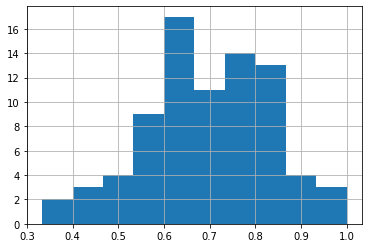

In [8]:
df['tapn'] = df['ttt'].apply(lambda x: get_apn(x, ytvs, fold='ttt'))
df['tapn'].apply(lambda r: get_ds_acc(*r)).hist()
df['tapn'].apply(lambda r: get_ds_acc(*r)).mean()

In [26]:
from itertools import chain
ttt = np.vstack(list(chain(df['ttt'])))
vtt = np.vstack(list(chain(df['vtt'])))
stt = np.vstack(list(chain(df['stt'])))

In [11]:
emb = {}
for model in ['RESN', 'TN']:
    for fold in ['train', 'valid', 'test']:
        if model not in emb:
            emb[model] = {}
        emb[model][fold] = pickle.load(open(f'../embeds/bm/prolific/{model}_{fold}_emb512.pkl', 'rb'))

In [12]:
drst = euc_dist(emb['RESN']['test'], emb['RESN']['train'])
# dmst = euc_dist(emb['MTL']['test'], emb['MTL']['train'])
dtst = euc_dist(emb['TN']['test'], emb['TN']['train'])

In [13]:
def get_nn_tup(dist, y_test, y_train):
    mask_test = np.tile(y_test, (len(y_train), 1)).T
    mask_train = np.tile(y_train, (len(y_test), 1))
    mask_in = mask_test == mask_train
    mask_out = mask_test != mask_train
    apply_mask = lambda x, m: x + (-(m - 1) * x.max())
    in1nn = np.argmin(apply_mask(dist, mask_in), 1)
    out1nn = np.argmin(apply_mask(dist, mask_out), 1)
    nn_tup = np.vstack([np.arange(len(y_test)), in1nn, out1nn])
    return nn_tup.T

def eval_nn_tup(dist, nn_tup, y_test, y_train):
    dst = dist.take(nn_tup[:,0], 0)
    dap = np.take_along_axis(dst, nn_tup[:,1].reshape(-1,1), 1).ravel()
    dan = np.take_along_axis(dst, nn_tup[:,2].reshape(-1,1), 1).ravel()
    pp = y_train.take(nn_tup[:,1]).ravel()
    pn = y_train.take(nn_tup[:,2]).ravel()
    pa = np.zeros((len(nn_tup)))
    pa[dap < dan] = pp[dap < dan]
    pa[dap >= dan] = pn[dap >= dan]
    y_true = y_test.take(nn_tup[:,0])
    return pa == y_true

In [11]:
rstt1nn = get_nn_tup(drst, y_test, y_train)
rcorr = eval_nn_tup(drst, rstt1nn, y_test, y_train)
mcorr = eval_nn_tup(dmst, rstt1nn, y_test, y_train)
tcorr = eval_nn_tup(dtst, rstt1nn, y_test, y_train)
rcorr.mean(), mcorr.mean(), tcorr.mean()

(0.875, 0.675, 0.65)

In [12]:
rnn1c = pickle.load(open('../examples/nn_1class/bm_RESN.pkl', 'rb'))
mnn1c = pickle.load(open('../examples/nn_1class/bm_MTL.pkl', 'rb'))

In [13]:
def get_path(nn_mat, i2p_test, i2p_train):
    path_mat = np.zeros_like(nn_mat).astype(str)
    path_mat[:,0] = np.vectorize(i2p_test.get)(nn_mat[:,0])
    path_mat[:,1:] = np.vectorize(i2p_train.get)(nn_mat[:,1:])
    return path_mat

In [16]:
mat = np.vstack([np.arange(len(y_test)), rnn1c, mnn1c]).T
# mat = get_path(mat, i2p_test, i2p_train)
# pickle.dump(mat, open('../examples/nn_1class/bm_RESN_MTL.pkl', 'wb'))

In [32]:
get_path(mat, i2p_test, i2p_train)[37]

array(['197.jpg', '183.jpg', '173.jpg'], dtype='<U21')

In [28]:
def get_nn_mat(dist, y_test, y_train):
    mask_train = np.tile(y_train, (len(y_test), 1))
    apply_mask = lambda x, m: x + (-(m - 1) * x.max())
    nn_mat = np.arange(len(y_test)).reshape(-1, 1)
    for label in np.sort(np.unique(y_train)):
        mask_in = label == mask_train
        in1nn = np.argmin(apply_mask(dist, mask_in), 1)
        nn_mat = np.hstack([nn_mat, in1nn.reshape(-1, 1)])
    return nn_mat

def eval_nn_mat(dist, nn_mat, y_test, y_train):
    dst = dist.take(nn_mat[:,0], 0)
    dnn = np.vstack([np.take_along_axis(dst, nn_mat[:,1+c].reshape(-1,1), 1).ravel() for c in np.sort(np.unique(y_train))])
    y_true = y_test.take(nn_mat[:,0])
    return dnn.argmin(0) == y_true

def choose_nn_mat(dist, nn_mat):
    dst = dist.take(nn_mat[:,0], 0)
    dnn = np.vstack([np.take_along_axis(dst, nn_mat[:,1+c].reshape(-1,1), 1).ravel() for c in np.sort(np.unique(y_train))])
    return dnn.argmin(0)

In [32]:
eval_nn_mat(, stt, y_test, y_train).mean()

0.495

In [22]:
diff = mat[:,1] != mat[:,2]

In [23]:
choose_nn_mat(drst, mat)[diff].mean()

0.0

In [28]:
choose_nn_mat(dmst, mat)[diff].mean()

1.0

In [29]:
choose_nn_mat(dtst, mat)[diff].mean()

0.5555555555555556

In [33]:
import embed_evals as evals

In [36]:
evals.get_knn_score(emb['TN']['train'], y_train, emb['TN']['test'], y_valid)

0.75

In [15]:
rstt1nn_mat = get_nn_mat(drst, y_test, y_train)
rcorr = eval_nn_mat(drst, rstt1nn_mat, y_test, y_train)
mcorr = eval_nn_mat(dmst, rstt1nn_mat, y_test, y_train)
tcorr = eval_nn_mat(dtst, rstt1nn_mat, y_test, y_train)
rcorr.mean(), mcorr.mean(), tcorr.mean()

(0.875, 0.675, 0.65)

In [16]:
mstt1nn_mat = get_nn_mat(dmst, y_test, y_train)
rcorr = eval_nn_mat(drst, mstt1nn_mat, y_test, y_train)
mcorr = eval_nn_mat(dmst, mstt1nn_mat, y_test, y_train)
tcorr = eval_nn_mat(dtst, mstt1nn_mat, y_test, y_train)
rcorr.mean(), mcorr.mean(), tcorr.mean()

(0.825, 0.675, 0.625)

In [17]:
tstt1nn_mat = get_nn_mat(dtst, y_test, y_train)
rcorr = eval_nn_mat(drst, tstt1nn_mat, y_test, y_train)
mcorr = eval_nn_mat(dmst, tstt1nn_mat, y_test, y_train)
tcorr = eval_nn_mat(dtst, tstt1nn_mat, y_test, y_train)
rcorr.mean(), mcorr.mean(), tcorr.mean()

(0.85, 0.7, 0.75)

In [19]:
mstt1nn = get_nn_tup(dmst, y_test, y_train)
rcorr = eval_nn_tup(drst, mstt1nn, y_test, y_train)
mcorr = eval_nn_tup(dmst, mstt1nn, y_test, y_train)
tcorr = eval_nn_tup(dtst, mstt1nn, y_test, y_train)
rcorr.mean(), mcorr.mean(), tcorr.mean()

(0.825, 0.675, 0.625)

In [ ]:
mat = mstt1nn[~mcorr].T
fig, ax = plt.subplots(3, mat.shape[1], figsize=(mat.shape[1]*10, 3*10))
from itertools import product
for i, j in product(range(mat.shape[0]), range(mat.shape[1])):
    img = test_ds[mat[i, j]][0] if i == 0 else train_ds[mat[i, j]][0]
    ax[i, j].imshow(img)
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])

In [20]:
tstt1nn = get_nn_tup(dtst, y_test, y_train)
rcorr = eval_nn_tup(drst, tstt1nn, y_test, y_train)
mcorr = eval_nn_tup(dmst, tstt1nn, y_test, y_train)
tcorr = eval_nn_tup(dtst, tstt1nn, y_test, y_train)
rcorr.mean(), mcorr.mean(), tcorr.mean()

(0.85, 0.7, 0.75)

In [ ]:
mat = tstt1nn[~tcorr].T
fig, ax = plt.subplots(3, mat.shape[1], figsize=(mat.shape[1]*10, 3*10))
from itertools import product
for i, j in product(range(mat.shape[0]), range(mat.shape[1])):
    img = test_ds[mat[i, j]][0] if i == 0 else train_ds[mat[i, j]][0]
    ax[i, j].imshow(img)
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])

In [ ]:
mat = rstt1nn.T
mat[2] = mstt1nn.T[1]
fig, ax = plt.subplots(3, mat.shape[1], figsize=(mat.shape[1]*10, 3*10))
from itertools import product
for i, j in product(range(mat.shape[0]), range(mat.shape[1])):
    img = test_ds[mat[i, j]][0] if i == 0 else train_ds[mat[i, j]][0]
    ax[i, j].imshow(img)
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])